# Autonomous Literature Review (AutoLit) Pipeline

In [1]:
# Load Test data
title = "Feasibility of Artificial Intelligence Driven Analysis in the Context of Nepalese Legal System"
abstract = "We proposed an innovative solution through an Artificial Intelligence driven legal analysis customized to the utility of the Nepalese legal context. Using advanced machine learning (ML) models and Retrieval-Augmented Generation (RAG) techniques, the research provides legal insights, streamlines judicial processes, and enhances accessibility to legal information. The legal documents were processed to convert into JSON format, and then to convert into vector data. GPT-4o was used for query expansion and response generation, whereas text embeddings were generated through text-embedding-ada-002. Key features include efficient document retrieval and query expansion for enhanced search precision. The model performs well across different query types, achieving an 𝐹1 score of 0.797 for rule-recall, 0.857 for rhetorical understanding, and 0.875 for interpretation-based queries. This work marks a significant step towards integrating AI into the legal domain of Nepal."

In [2]:
from dotenv import load_dotenv
load_dotenv()

python-dotenv could not parse statement starting at line 4


True

In [3]:
# Keyword Generation
import os
from fastapi import HTTPException
import requests
from typing import Dict, List
import hdbscan
from sentence_transformers import SentenceTransformer, util
import json
from collections import defaultdict
from sklearn.preprocessing import StandardScaler

def keyword_gen(title: str, abstract: str) -> list[str]:
    GEMINI_API_URL = os.environ.get("GEMINI_API_URL") or ""
    res = requests.post(GEMINI_API_URL, json={
        "contents": [{
            "parts": [{
                "text": f"""
                    Extract 5–10 relevant and concise keywords from the following
                    research paper title and abstract. Each keyword should be 1–3
                    words long. Return only the keywords as a plain list, one per
                    line. Don't say anything else.

                    Title: {title}

                    Abstract: {abstract}
                """
                }]
            }]
    })

    if not res.ok:
        print(res.json())
        raise HTTPException(status_code=500)

    res = res.json()

    keywords_str: str = res["candidates"][0]["content"]["parts"][0]["text"]
    keywords = keywords_str.split("\n")
    return [keyword for keyword in keywords if keyword.strip() != ""]

keywords = keyword_gen(title, abstract)
print(keywords)

['Artificial Intelligence', 'Legal System', 'Nepalese Legal Context', 'Machine Learning', 'RAG', 'Legal Analysis', 'GPT-4o', 'Text Embeddings', 'Document Retrieval', 'Query Expansion']


In [4]:
# Retrieve Papers

from typing import List
import requests
import xmltodict
import time

ARXIV_URI = "https://export.arxiv.org/api/query"


ARXIV_URI = "https://export.arxiv.org/api/query"
HEADERS = {
    "User-Agent": "YourAppName/1.0 (Contact: your-email@example.com)"
}

'''
Sample query	Error Explanation
http://export.arxiv.org/api/query?start=not_an_int	start must be an integer
http://export.arxiv.org/api/query?start=-1	start must be >= 0
http://export.arxiv.org/api/query?max_results=not_an_int	max_results must be an integer
http://export.arxiv.org/api/query?max_results=-1	max_results must be >= 0
http://export.arxiv.org/api/query?id_list=1234.1234	malformed id - see arxiv identifier explanation
http://export.arxiv.org/api/query?id_list=cond—mat/0709123	malformed id - see arxiv identifier explanation

'''
def validate_arxiv_query_params(start: int, max_results: int):
    if not isinstance(start, int) or start < 0:
        raise ValueError("start must be a non-negative integer")
    if not isinstance(max_results, int) or max_results <= 0:
        raise ValueError("max_results must be a positive integer")

def fetch_arxiv_data(query: str, start: int = 0, max_results: int = 10, retries: int = 3, delay: float = 3.0) -> List[dict]:
    validate_arxiv_query_params(start, max_results)

    params = {
        'search_query': query,
        'start': start,
        'max_results': max_results
    }

    for attempt in range(retries):
        try:
            response = requests.get(ARXIV_URI, params=params, headers=HEADERS, timeout=10)
            response.raise_for_status()

            if not response.text.strip():
                raise Exception("Empty response from arXiv")

            parsed_response = xmltodict.parse(response.text)
            entries = parsed_response.get('feed', {}).get('entry', [])

            if isinstance(entries, dict):
                entries = [entries]

            if not entries:
                return []

            papers = []
            for entry in entries:
                authors_data = entry.get('author', [])
                if isinstance(authors_data, dict):
                    authors = [authors_data.get('name', '')]
                elif isinstance(authors_data, list):
                    authors = [author.get('name', '') for author in authors_data]
                else:
                    authors = []

                categories_data = entry.get('category', [])
                if isinstance(categories_data, dict):
                    categories = [categories_data.get('@term', '')]
                elif isinstance(categories_data, list):
                    categories = [cat.get('@term', '') for cat in categories_data]
                else:
                    categories = []

                links_data = entry.get('link', [])
                if isinstance(links_data, dict):
                    links_data = [links_data]
                links = {link.get('@rel', ''): link.get('@href', '') for link in links_data}

                paper = {
                    'id': entry.get('id', ''),
                    'title': entry.get('title', '').strip(),
                    'summary': entry.get('summary', '').strip(),
                    'published': entry.get('published', ''),
                    'updated': entry.get('updated', ''),
                    'authors': authors,
                    'categories': categories,
                    'links': links
                }

                papers.append(paper)

            time.sleep(delay)  # rate limit
            return papers

        except requests.exceptions.RequestException as e:
            if attempt < retries - 1:
                time.sleep(2 ** attempt)
                continue
            raise Exception(f"Request to arXiv failed after {retries} attempts: {str(e)}")
        except Exception as e:
            raise Exception(f"An error occurred while processing the response: {str(e)}")

def retrieve_papers(keyword, max_results=20):
    return fetch_arxiv_data(query=keyword, max_results=max_results, start=0)

papers_unfiltered = []
for keyword in keywords:
    papers_unfiltered = papers_unfiltered + retrieve_papers(keyword=keyword)

# Remove repeated
papers = []
seen_ids = set()
for paper in papers_unfiltered:
    if paper['id'] not in seen_ids:
        papers.append(paper)
        seen_ids.add(paper['id'])

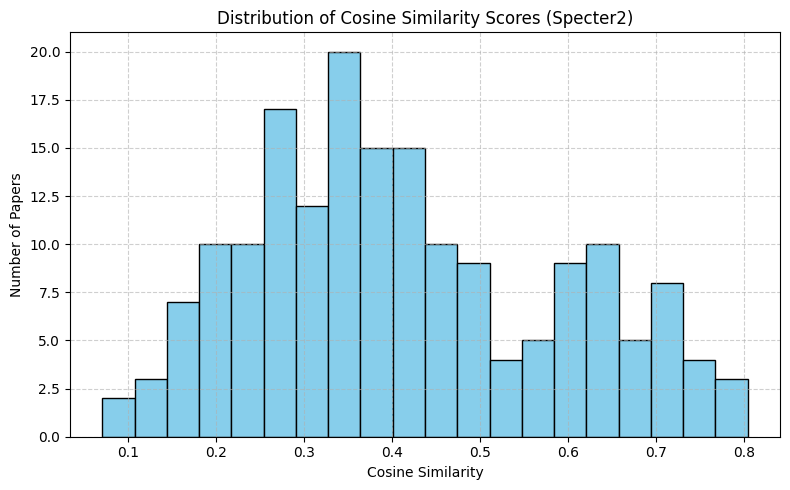

[0.15479067 0.28961575 0.2331697  0.19001873 0.17949927 0.1810281
 0.13682112 0.2046005  0.30562168 0.2768539  0.09972487 0.3230602
 0.19035554 0.4750857  0.24056771 0.19516337 0.28272504 0.17054217
 0.16508743 0.16263646 0.6616254  0.74161124 0.3382957  0.54766417
 0.74790424 0.6704902  0.71821725 0.6891277  0.625416   0.61980736
 0.78067285 0.6426154  0.70857406 0.70427096 0.68438405 0.3459803
 0.5018354  0.7073923  0.60683703 0.6389086  0.7278058  0.6220193
 0.31315586 0.6597229  0.580132   0.6356472  0.5315417  0.5346875
 0.6501758  0.6178029  0.61243427 0.6524634  0.6047032  0.75937617
 0.6453794  0.70792985 0.5882892  0.6245441  0.5696595  0.17020369
 0.1532691  0.22442779 0.3489324  0.29236302 0.21118891 0.22254397
 0.26469353 0.25756252 0.20925707 0.2835125  0.28783482 0.31108707
 0.26559922 0.23535389 0.25958103 0.3210634  0.12033057 0.27153742
 0.23647682 0.28252238 0.43096378 0.38142136 0.4673099  0.38265413
 0.31240138 0.3796569  0.3552903  0.39097863 0.50617534 0.36421463


tensor(0.6594, device='cuda:0')

papers count 20


In [23]:
# Retrieve Relevant Papers
from typing import List, Dict
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import torch

model = SentenceTransformer('all-MiniLM-L6-v2')
# model = SentenceTransformer('allenai/specter2_base')

def retrieve_relevant_papers(title: str, abstract: str, related_papers: List[Dict]) -> List[Dict[str,str]]:
    '''
    Retrieve the top k related papers based on the title and abstract of a given paper.
    '''
    if not related_papers:
        return []
    
    # Generate embeddings for the title and abstract
    query = f"{title.strip()} {abstract.strip()}"

    query_embedding = model.encode(query, convert_to_tensor=True)

    # Prepare the contents of the related papers for embedding

    paper_contents = []

    for paper in related_papers:
        paper_title = paper.get('title', '').strip()
        paper_abstract = paper.get('summary', '').strip()
        paper_contents.append(f"{paper_title} {paper_abstract}")

    paper_embeddings = model.encode(paper_contents, convert_to_tensor=True)

    # Compute cosine similarities
    cosine_scores = util.cos_sim(query_embedding, paper_embeddings)[0]

    # Convert tensor to NumPy array (if needed)
    scores = cosine_scores.cpu().numpy()  # .cpu() in case you're on GPU
    
    # Plot histogram
    plt.figure(figsize=(8, 5))
    plt.hist(scores, bins=20, color='skyblue', edgecolor='black')
    plt.title("Distribution of Cosine Similarity Scores (Specter2)")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Number of Papers")
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

    print(scores)
    # min_papers = 8

    # thresholds = [0.7, 0.65, 0.6]
    # for threshold in thresholds:
    #     relevant_indices = (cosine_scores >= threshold).nonzero(as_tuple=True)[0]
    #     if len(relevant_indices) >= min_papers or threshold == thresholds[-1]:
    #         relevant_papers = [related_papers[i] for i in relevant_indices.tolist()]
    #         return relevant_papers

    q1 = torch.quantile(cosine_scores, 0.25)
    q3 = torch.quantile(cosine_scores, 0.75)
    iqr = q3 - q1
    
    # Set threshold at Q3 + 0.5 * IQR
    threshold = q3 + 0.5 * iqr
    display(threshold)

    relevant_indices = (cosine_scores >= threshold).nonzero(as_tuple=True)[0]
    relevant_papers = [related_papers[i] for i in relevant_indices.tolist()]
    return relevant_papers
    
top_papers = retrieve_relevant_papers(title, abstract, papers)
print("papers count", len(top_papers))

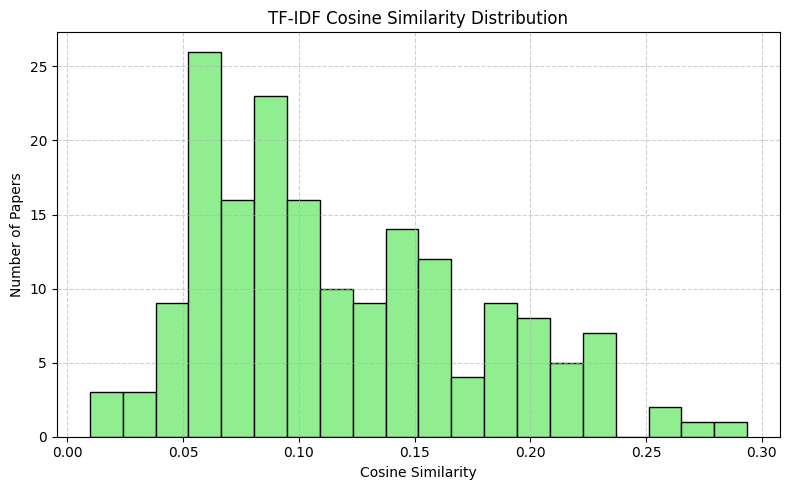

[0.10648842 0.09795321 0.11458513 0.09911362 0.06095786 0.05983426
 0.0630122  0.08724986 0.05059243 0.14864017 0.08553032 0.11805229
 0.09289445 0.15800582 0.10724016 0.08410922 0.07552604 0.05704606
 0.06080474 0.06439626 0.21939674 0.22940465 0.14288316 0.1813935
 0.25210014 0.23525369 0.23561514 0.19114569 0.22369851 0.16275971
 0.29363293 0.18996276 0.23082619 0.18345706 0.23322002 0.20487084
 0.15218491 0.20157775 0.13953675 0.21074255 0.26051574 0.23288508
 0.04602708 0.1889613  0.20758422 0.16657148 0.14858099 0.0861242
 0.20397662 0.15946445 0.12776654 0.16577467 0.21107282 0.18983868
 0.13610177 0.14706702 0.11497049 0.19670606 0.13432159 0.02230458
 0.03885837 0.0335094  0.05645392 0.08833458 0.04324545 0.05380734
 0.07274057 0.05833361 0.05505027 0.06080204 0.04640566 0.06661121
 0.0506983  0.06767598 0.06120221 0.06356464 0.00968709 0.01884327
 0.03002415 0.09151831 0.08297948 0.06185122 0.06563553 0.05284702
 0.11729718 0.11124718 0.10826641 0.06414362 0.07613133 0.061522

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from typing import List, Dict
import matplotlib.pyplot as plt
import numpy as np

def retrieve_relevant_papers_tfidf(title: str, abstract: str, related_papers: List[Dict]) -> List[Dict[str,str]]:
    '''
    Retrieve top related papers using TF-IDF + Cosine Similarity.
    '''
    if not related_papers:
        return []

    # Combine query and documents
    query = f"{title.strip()} {abstract.strip()}"

    paper_contents = []
    for paper in related_papers:
        paper_title = paper.get('title', '').strip()
        paper_abstract = paper.get('summary', '').strip()
        paper_contents.append(f"{paper_title} {paper_abstract}")

    all_texts = [query] + paper_contents  # Query goes first

    # Create TF-IDF vectorizer and fit
    vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
    tfidf_matrix = vectorizer.fit_transform(all_texts)

    # Compute cosine similarity (query vs each document)
    cosine_scores = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()

    # Plot histogram
    plt.figure(figsize=(8, 5))
    plt.hist(cosine_scores, bins=20, color='lightgreen', edgecolor='black')
    plt.title("TF-IDF Cosine Similarity Distribution")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Number of Papers")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    print(cosine_scores)

    # Use IQR method
    q1 = np.quantile(cosine_scores, 0.25)
    q3 = np.quantile(cosine_scores, 0.75)
    iqr = q3 - q1
    threshold = q3 + 0.5 * iqr
    print("Threshold:", threshold)

    # Select relevant papers
    relevant_indices = np.where(cosine_scores >= threshold)[0]
    relevant_papers = [related_papers[i] for i in relevant_indices.tolist()]
    return relevant_papers

top_papers = retrieve_relevant_papers_tfidf(title, abstract, papers)
print("papers count", len(top_papers))

In [ ]:
__import__('pprint').pprint(top_papers[0])

In [62]:
# Extract Text From PDFs

import fitz  # PyMuPDF
import requests
import re
from io import BytesIO

def extract_text_from_pdf(pdf_source, filetype=None) -> str:
    if filetype:
        doc = fitz.open(stream=pdf_source, filetype=filetype)
    else:
        doc = fitz.open(pdf_source)
    text = ""
    for page in doc:
        text += page.get_text()
    return text

def extract_text_from_url(url: str) -> str:
    response = requests.get(url)
    if response.ok:
        return extract_text_from_pdf(BytesIO(response.content), filetype="pdf")
    return ""

def split_into_sections(text: str) -> Dict[str, str]:
    sections = {
        'title': '',
        'abstract': '',
        'introduction': '',
        'methods': '',
        'results': '',
        'conclusion': '',
    }

    # Very crude split based on keywords
    section_patterns = {
        'abstract': r'(?i)\babstract\b',
        'introduction': r'(?i)\bintroduction\b',
        'methods': r'(?i)\b(methodology|methods|approach)\b',
        'results': r'(?i)\b(results|findings|experiments)\b',
        'conclusion': r'(?i)\b(conclusion|discussion|summary)\b'
    }

    current_section = 'title'
    lines = text.split('\n')
    buffer = []

    for line in lines:
        line_clean = line.strip()
        if not line_clean:
            continue

        matched = False
        for sec, pattern in section_patterns.items():
            if re.fullmatch(pattern, line_clean.lower()):
                sections[current_section] = '\n'.join(buffer).strip()
                buffer = []
                current_section = sec
                matched = True
                break

        if not matched:
            buffer.append(line_clean)

    # Save final section
    sections[current_section] = '\n'.join(buffer).strip()

    return sections

papers_extracted = []
for paper in top_papers:
    paper_links = paper.get('links')
    if not paper_links:
        continue
    paper_links_related = paper_links.get('related')
    if not paper_links_related:
        continue
    try:
        full_text = extract_text_from_url(paper_links_related)
        sectioned_text = split_into_sections(full_text)

        paper_extracted = {
            **paper,  # keep original metadata: title, authors, etc.
            "sections": sectioned_text  # add structured content
        }

        papers_extracted.append(paper_extracted)

    except Exception as e:
        print(f"Error processing {paper.get('title')}: {e}")
print(len(top_papers), len(papers_extracted))

12 12


In [64]:
print(papers_extracted[0].keys())

dict_keys(['id', 'title', 'summary', 'published', 'updated', 'authors', 'categories', 'links', 'sections'])


In [84]:
# Summarize pdfs using gemini
import time
import os
import requests
import json
from typing import Dict, Any

def get_gemini_dict_response(prompt_text: str) -> Dict[str, Any]:
    """
    Sends a prompt to the Gemini API and returns the parsed JSON response as a dictionary.
    Assumes GEMINI_API_URL is set in environment variables and includes necessary auth.
    This function specifically handles cases where Gemini wraps JSON output in markdown code blocks.
    """
    GEMINI_API_URL = os.environ.get("GEMINI_API_URL")
    if not GEMINI_API_URL:
        raise ValueError("GEMINI_API_URL env var not set.")

    payload = {"contents": [{"parts": [{"text": prompt_text}]}]}
    
    try:
        res = requests.post(GEMINI_API_URL, json=payload)
        res.raise_for_status() # Raises HTTPError for bad responses (4xx or 5xx)
        
        response_data = res.json()

        # Extract the text content from the Gemini response structure
        # This is where the actual JSON string generated by Gemini will be
        if "candidates" in response_data and \
           response_data["candidates"] and \
           "content" in response_data["candidates"][0] and \
           "parts" in response_data["candidates"][0]["content"] and \
           response_data["candidates"][0]["content"]["parts"] and \
           "text" in response_data["candidates"][0]["content"]["parts"][0]:
            
            gemini_generated_text = response_data["candidates"][0]["content"]["parts"][0]["text"]
            
            # --- CRITICAL FIX HERE ---
            # Remove markdown code block delimiters if present
            if gemini_generated_text.startswith("```json") and gemini_generated_text.endswith("```"):
                # Remove the '```json\n' from the start and '\n```' from the end
                json_string = gemini_generated_text[len("```json\n"):-len("\n```")]
            else:
                json_string = gemini_generated_text
            # --- END CRITICAL FIX ---

            # Now, attempt to parse the cleaned JSON string
            return json.loads(json_string)
            
        else:
            raise ValueError("Gemini response did not contain expected content structure.")

    except requests.exceptions.RequestException as e:
        print(f"Error making request to Gemini API: {e}")
        if 'res' in locals():
            print(f"Response content: {res.text}")
        raise
    except json.JSONDecodeError as e:
        print(f"Failed to parse JSON from Gemini's text output: {e}")
        if 'json_string' in locals():
            print(f"Attempted to parse: {json_string}")
        raise
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        raise

def summarize_pdf(pdf_extracted):
    sections = pdf_extracted['sections']
    full_text_for_summary = f"""
Title: {sections.get('title', '')}
Abstract: {sections.get('abstract', '')}
Introduction: {sections.get('introduction', '')}
Methods: {sections.get('methods', '')}
Results: {sections.get('results', '')}
Conclusion: {sections.get('conclusion', '')}"""
    
    prompt = f"""
Summarize the following research paper into a JSON object.
The JSON object should have the following structure:
{{
    "title": "...",
    "summary": {{
        "problem_statement": ["bullet point 1", "bullet point 2", ...],
        "methodology": ["bullet point 1", "bullet point 2", ...],
        "key_findings": ["bullet point 1", "bullet point 2", ...],
        "conclusion_recommendations": ["bullet point 1", "bullet point 2", ...]
    }}
}}

Ensure all summaries are concise bullet points.

Paper Text:
---
{full_text_for_summary}
---"""
    try:
        response_dict = get_gemini_dict_response(prompt)
        return json.dumps(response_dict, indent=2)

    except Exception as e:
        print(f"Error: {e}")

for paper_extracted in papers_extracted:
    paper_extracted['summarized'] = summarize_pdf(paper_extracted)
    time.sleep(2)
    

In [86]:
for paper in papers_extracted:
    paper['summarized'] = json.loads(paper['summarized'])

In [77]:
__import__('pprint').pprint([paper.keys() for paper in papers_extracted])

[dict_keys(['id', 'title', 'summary', 'published', 'updated', 'authors', 'categories', 'links', 'sections', 'summarized', 'citation_intent', 'contribution_type']),
 dict_keys(['id', 'title', 'summary', 'published', 'updated', 'authors', 'categories', 'links', 'sections', 'summarized', 'citation_intent', 'contribution_type']),
 dict_keys(['id', 'title', 'summary', 'published', 'updated', 'authors', 'categories', 'links', 'sections', 'summarized', 'citation_intent', 'contribution_type']),
 dict_keys(['id', 'title', 'summary', 'published', 'updated', 'authors', 'categories', 'links', 'sections', 'summarized', 'citation_intent', 'contribution_type']),
 dict_keys(['id', 'title', 'summary', 'published', 'updated', 'authors', 'categories', 'links', 'sections', 'summarized']),
 dict_keys(['id', 'title', 'summary', 'published', 'updated', 'authors', 'categories', 'links', 'sections', 'summarized', 'citation_intent', 'contribution_type']),
 dict_keys(['id', 'title', 'summary', 'published', 'upda

In [79]:
# Citation Intent and Contribution Tagging

for paper in papers_extracted:
    try:
        prompt = f"""Given the following research paper summary and title, return a JSON object that contains:
- `intent`: Citation intent — one of ["Background", "Comparison", "Extension", "Criticism", "Application", "Future Work", "Other"]
- `contribution`: Contribution type — one of ["Dataset", "Algorithm", "Framework", "Review", "Benchmark", "Survey", "System", "Theoretical Analysis", "Other"]

The JSON object should look like:
{{
  "intent": "...",
  "contribution": "..."
}}

Title: {title}

Summary:
{json.dumps(paper['summarized'], indent=2)}

Only return the JSON object. Do not include any explanation or markdown formatting.
"""
        result = get_gemini_dict_response(prompt)
        paper['citation_intent'] = result.get('intent')
        paper['contribution_type'] = result.get('contribution')
        time.sleep(2)
    except Exception as e:
        print(f"Skipping {paper['title']}: {e}")
        time.sleep(2)

In [88]:
__import__('pprint').pprint(papers_extracted[0]['summarized'])

{'summary': {'conclusion_recommendations': ['Further research and development '
                                            "are needed to improve LLMs' "
                                            'understanding of complex legal '
                                            'language and reasoning.',
                                            'Training methodologies should '
                                            'integrate domain-specific legal '
                                            'knowledge and strengthen '
                                            'reasoning capabilities.',
                                            'Develop more interpretable models '
                                            'and incorporate human expertise '
                                            'in the decision-making process.',
                                            'Implement robust ethical review '
                                            'mechanisms to ensure model '
     

In [ ]:
def to_bibtex_entry(paper):
    authors = " and ".join(paper["authors"])
    year = paper["published"][:4]
    arxiv_id = paper["id"].split("/")[-1]
    
    return f"""
@article{{{arxiv_id},
  title={{ {paper['title']} }},
  author={{ {authors} }},
  year={{ {year} }},
  archivePrefix={{arXiv}},
  eprint={{ {arxiv_id} }},
  url={{ {paper['id']} }},
  note={{ Preprint }},
}}
""".strip()


In [87]:
# Build literature review

def build_lit_review_prompt(papers: List[Dict[str, Any]]) -> str:
    entries_text = ""
    for paper in papers:
        title = paper.get("title", "Unknown Title")
        authors = ", ".join(paper.get("authors", [])[:3])
        year = paper.get("published", "")[:4] or "Unknown Year"
        intent = paper.get("citation_intent", "Other")
        contribution = paper.get("contribution_type", "Other")
        summary = paper.get("summarized", {})

        entries_text += f"""
🔸 Title: {title}
👥 Authors: {authors}
📅 Year: {year}
🎯 Intent: {intent}
💡 Contribution: {contribution}
📄 Summary:
- Problem: {"; ".join(summary.get("problem_statement", []))}
- Methodology: {"; ".join(summary.get("methodology", []))}
- Findings: {"; ".join(summary.get("key_findings", []))}
- Conclusion: {"; ".join(summary.get("conclusion_recommendations", []))}

"""

    return f"""You are a research assistant helping write the literature review section of a research paper.

Below are structured notes for several research papers. Your task is to write a coherent, academic-style literature review summarizing these works. Integrate them logically by theme, contribution type, or research direction (e.g., Background, Comparison, Extension...).

Use proper citations (e.g., "Wang et al. (2024)") and mention paper titles only when helpful. Write in an academic tone with smooth transitions.

Input papers:
{entries_text}

Begin the literature review now:"""


def get_gemini_text_response(prompt_text: str) -> str:
    GEMINI_API_URL = os.environ.get("GEMINI_API_URL")
    payload = {"contents": [{"parts": [{"text": prompt_text}]}]}
    res = requests.post(GEMINI_API_URL, json=payload)
    res.raise_for_status()
    return res.json()["candidates"][0]["content"]["parts"][0]["text"].strip()

lit_review_prompt = build_lit_review_prompt(papers_extracted)
lit_review_paragraph = get_gemini_text_response(lit_review_prompt)
print(lit_review_paragraph)

The application of Natural Language Processing (NLP) to the legal domain has garnered increasing attention in recent years. Several studies have provided background and context for this burgeoning field. Zhong et al. (2020) offer a broad overview of how NLP benefits the legal system, summarizing the landscape of Legal Artificial Intelligence. Qin and Sun (2024) similarly explore the intersection of Large Language Models (LLMs) and legal systems in a concise survey. Focusing on the Indian legal landscape, Kalamkar et al. (2021) present a survey of Indian Legal NLP benchmarks, highlighting the specific challenges and opportunities within that context.

A significant area of research involves the development of specialized datasets and benchmarks for legal NLP tasks. Nigam et al. (2024) introduce NyayaAnumana & INLegalLlama, a large dataset designed for Indian legal judgment prediction. Concurrently, Nigam et al. (2024) also presented PredEx, contributing to the rise of intelligent AI int